In [2]:
import torch
import numpy
import torch.nn as nn
from torchvision import transforms
import torchvision.datasets
import matplotlib.pyplot as plt
import math
import wandb
import torch.utils.data

device = 'cuda' if torch.cuda.is_available() else 'cpu'

/home/jacopo/hlt/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_size = 0.8
val_size = 0.2
generator_gpu = torch.Generator(device=device).manual_seed(42)
generator = torch.Generator().manual_seed(42)

In [4]:
'''def normalization(tensor, min_value, max_value):
    min_tensor = tensor.min()
    tensor = (tensor - min_tensor)
    max_tensor = tensor.max()
    tensor = tensor / max_tensor
    tensor = tensor * (max_value - min_value) + min_value
    
    return torch.round(tensor)


img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda tensor:normalization(tensor, 0, 1))
])
'''
def add_noise(img_tensor, std=0.4):
    return (img_tensor + torch.randn(img_tensor.size(), generator=generator_gpu, device=device) * std)

In [5]:
train_data  = torchvision.datasets.MNIST("./data", train=True, transform=transforms.ToTensor(), download=False)
test_data = torchvision.datasets.MNIST("./data", train=False, transform=transforms.ToTensor(), download=False)

data_size = len(train_data)

In [6]:
len(train_data), len(test_data)

(60000, 10000)

In [7]:
train_set, val_set = torch.utils.data.random_split(train_data, [int(train_size*data_size), int(val_size*data_size)], generator=generator)

In [8]:
len(train_set), len(val_set)

(48000, 12000)

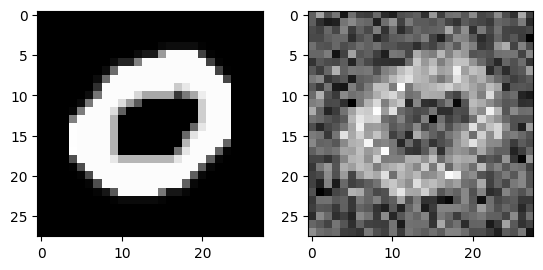

In [9]:
fig, ax = plt.subplots(1, 2)
j = 69
x, _ = train_set[j]
ax[0].imshow(x.numpy()[0], cmap='gray')
ax[1].imshow(add_noise(x.to(device)).cpu().numpy()[0], cmap='gray')

In [10]:
class ConvAE(nn.Module):
    def __init__(self, input_size = 28, hidden_size:int = 16, latent_size:int = 32, kernel_size:int = 3):
        super(ConvAE, self).__init__()

        linear_dim = (hidden_size) * (input_size//4) * (input_size//4)
        pad = (kernel_size - 1) // 2

        self.encoder = nn.Sequential(nn.Conv2d(1, hidden_size//2, kernel_size=kernel_size, padding=pad),
                                     nn.ReLU(), 
                                     nn.MaxPool2d(2, 2),
                                     nn.Conv2d(hidden_size//2, hidden_size, kernel_size=kernel_size, padding=pad),
                                     nn.ReLU(),
                                     nn.MaxPool2d(2, 2),
                                     nn.Flatten(),
                                     nn.Linear(linear_dim, latent_size),
                                     nn.ReLU()
                                     )
        
        self.decoder = nn.Sequential(nn.Linear(latent_size, linear_dim),
                                     nn.ReLU(), 
                                     nn.Unflatten(dim=1, unflattened_size=((hidden_size), (input_size//4), (input_size//4))),
                                     nn.ConvTranspose2d(hidden_size, hidden_size//2, kernel_size=2, stride=2), 
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(hidden_size//2, 1, kernel_size=2, stride=2), 
                                     nn.Sigmoid())

    def forward(self, x):
        x_e = self.encoder(x) 
    
        return self.decoder(x_e), x_e

In [11]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1024, shuffle=True, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=len(val_set), shuffle=False, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data), pin_memory=True)

In [12]:
def contractive_loss_function(base_loss, out_e, x, lamda):
    
    out_e.backward(gradient = torch.ones(out_e.size()).to(device), retain_graph=True)    
    # Frobenious norm, the square root of sum of all elements (square value) in a jacobian matrix 
    # loss2 = torch.sqrt(torch.sum(torch.pow(x.grad,2)))
    loss2 = torch.linalg.norm(x.grad)
    x.grad.data.zero_()
    loss = base_loss + (lamda*loss2) 
    return loss 

In [13]:
class Configuration:
        def __init__(self, learning_rate, batch_size, epochs, weight_decay, hidden_size, autoencoder_type, latent_size, cae_penalization):
            self.learning_rate = learning_rate
            self.batch_size = batch_size
            self.epochs = epochs
            self.weight_decay = weight_decay
            self.hidden_size = hidden_size
            self.latent_size = latent_size
            self.autoencoder_type = autoencoder_type
            self.cae_penalization = cae_penalization
        
config_cae = Configuration(learning_rate = 0.01,
                        batch_size = 1024,
                        epochs = 20,
                        weight_decay = 1e-5,
                        hidden_size = 64,
                        latent_size=128,
                        autoencoder_type = 'cae',
                        cae_penalization = 1e-5)

config_dae = Configuration(learning_rate = 0.01,
                        batch_size = 1024,
                        epochs = 20,
                        weight_decay = 1e-5,
                        hidden_size = 64,
                        latent_size=128,
                        autoencoder_type = 'dae',
                        cae_penalization = 1e-5)

In [14]:
def plot_img(model:nn.Module, mode:str):
    j = 2
    x, _ = test_data[j]
    x = x.to(device)
    x_noisy = add_noise(x)
    
    fig, ax = plt.subplots(1, 4, figsize=(15, 15))
    
    # clean input
    ax[0].imshow(x.to('cpu').numpy()[0], cmap='gray')
    out, _ = model(x.unsqueeze(0))
    ax[1].imshow(numpy.reshape((out.cpu().numpy()[0]), (28, 28)), cmap='gray')

    # noisy input
    ax[2].imshow(x_noisy.to('cpu').numpy()[0], cmap='gray')
    out, _ = model(x_noisy.unsqueeze(0))
    ax[3].imshow(numpy.reshape((out.cpu().numpy()[0]), (28, 28)), cmap='gray')

In [15]:
def train(config:Configuration=None, show_img:bool = False):
    #with wandb.init(config):
        model = ConvAE(hidden_size=config.hidden_size, latent_size=config.latent_size).to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
        criterion = torch.nn.MSELoss()
        val_criterion = torch.nn.L1Loss()

        epochs = config.epochs
        for epoch in range(epochs):
            model.train()
            tr_epoch_loss = 0
            for i, (input_img, _) in enumerate(train_loader):
                optimizer.zero_grad()

                input_img = input_img.to(device)

                if config.autoencoder_type == 'dae':
                    img_noisy = add_noise(input_img)
                    out, _ = model(img_noisy)
                
                    tr_loss = criterion(out, input_img)
                    tr_epoch_loss += tr_loss.item()

                else:
                    input_img.requires_grad_(True)
                    
                    out, out_e = model(input_img)
                    base_loss = criterion(out, input_img)
                    tr_loss = contractive_loss_function(base_loss=base_loss, out_e=out_e, x=input_img, lamda=config.cae_penalization)
                    tr_epoch_loss += base_loss.item()

                    input_img.requires_grad_(False)
                    optimizer.zero_grad()

                tr_loss.backward()
                optimizer.step()

            model.eval()
            with torch.no_grad():
                for input_img, _ in val_loader:
                    
                    input_img = input_img.to(device)
                    out, _ = model(input_img)
                        
                    val_loss = val_criterion(out, input_img)
                    bce_val_loss = criterion(out, input_img)

                print(f"epoch [{epoch + 1}/{epochs}], tr_loss: {tr_epoch_loss/(i+1):.4f}, L1_val_loss: {val_loss.item():.4f}, MSE_val_loss: {bce_val_loss.item():.4f}")

                if show_img and (epoch % 5 == 0):
                    plot_img(model, config.autoencoder_type)
        
        return model

epoch [1/20], tr_loss: 0.0784, L1_val_loss: 0.1225, MSE_val_loss: 0.0539
epoch [2/20], tr_loss: 0.0384, L1_val_loss: 0.0668, MSE_val_loss: 0.0265
epoch [3/20], tr_loss: 0.0232, L1_val_loss: 0.0516, MSE_val_loss: 0.0186
epoch [4/20], tr_loss: 0.0177, L1_val_loss: 0.0449, MSE_val_loss: 0.0155
epoch [5/20], tr_loss: 0.0143, L1_val_loss: 0.0392, MSE_val_loss: 0.0127
epoch [6/20], tr_loss: 0.0132, L1_val_loss: 0.0370, MSE_val_loss: 0.0115
epoch [7/20], tr_loss: 0.0114, L1_val_loss: 0.0349, MSE_val_loss: 0.0110
epoch [8/20], tr_loss: 0.0109, L1_val_loss: 0.0351, MSE_val_loss: 0.0105
epoch [9/20], tr_loss: 0.0105, L1_val_loss: 0.0386, MSE_val_loss: 0.0128
epoch [10/20], tr_loss: 0.0102, L1_val_loss: 0.0319, MSE_val_loss: 0.0093
epoch [11/20], tr_loss: 0.0096, L1_val_loss: 0.0319, MSE_val_loss: 0.0092
epoch [12/20], tr_loss: 0.0093, L1_val_loss: 0.0313, MSE_val_loss: 0.0089
epoch [13/20], tr_loss: 0.0097, L1_val_loss: 0.0343, MSE_val_loss: 0.0104
epoch [14/20], tr_loss: 0.0093, L1_val_loss: 0.

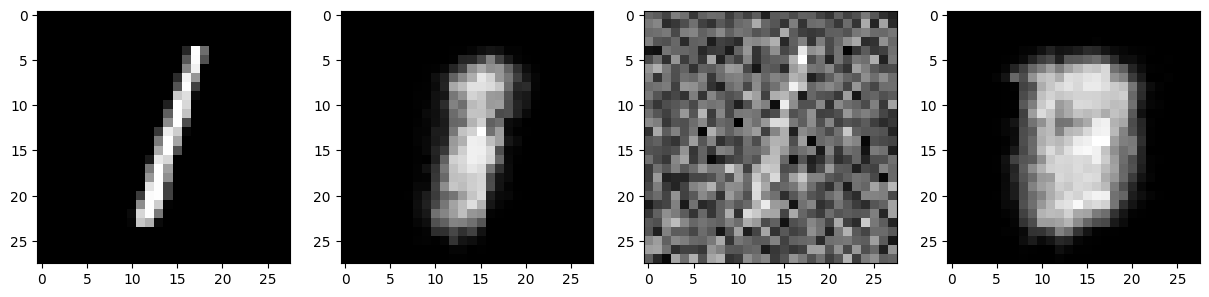

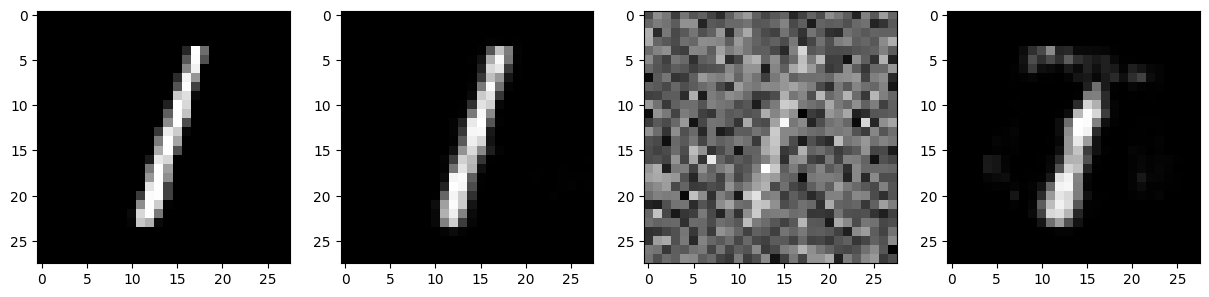

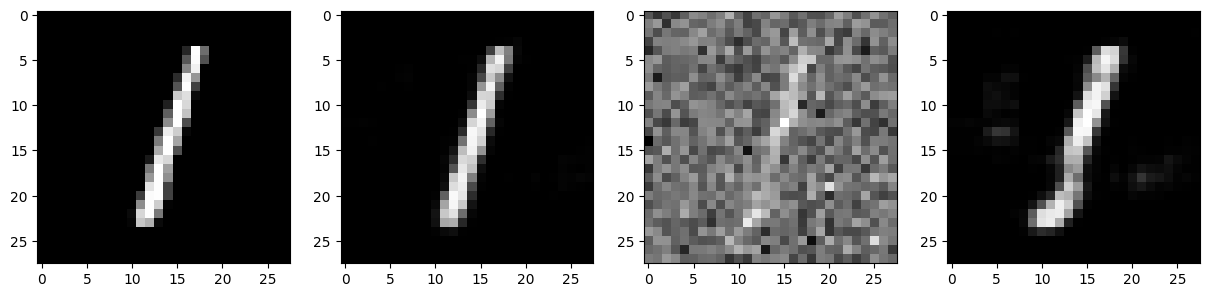

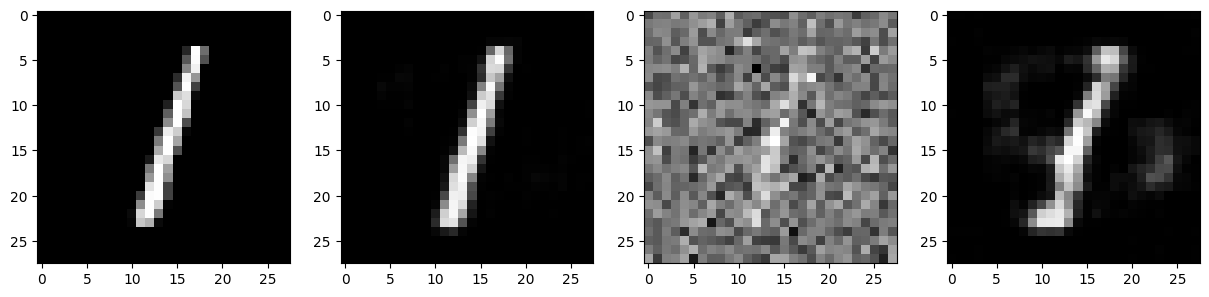

In [16]:
model_cae = train(config_cae, True)

epoch [1/20], tr_loss: 0.0792, L1_val_loss: 0.2436, MSE_val_loss: 0.0896
epoch [2/20], tr_loss: 0.0494, L1_val_loss: 0.1243, MSE_val_loss: 0.0512
epoch [3/20], tr_loss: 0.0356, L1_val_loss: 0.1056, MSE_val_loss: 0.0434
epoch [4/20], tr_loss: 0.0295, L1_val_loss: 0.0967, MSE_val_loss: 0.0412
epoch [5/20], tr_loss: 0.0257, L1_val_loss: 0.0816, MSE_val_loss: 0.0322
epoch [6/20], tr_loss: 0.0233, L1_val_loss: 0.0811, MSE_val_loss: 0.0339
epoch [7/20], tr_loss: 0.0210, L1_val_loss: 0.0689, MSE_val_loss: 0.0258
epoch [8/20], tr_loss: 0.0192, L1_val_loss: 0.0662, MSE_val_loss: 0.0243
epoch [9/20], tr_loss: 0.0189, L1_val_loss: 0.0651, MSE_val_loss: 0.0237
epoch [10/20], tr_loss: 0.0184, L1_val_loss: 0.0585, MSE_val_loss: 0.0197
epoch [11/20], tr_loss: 0.0178, L1_val_loss: 0.0606, MSE_val_loss: 0.0214
epoch [12/20], tr_loss: 0.0175, L1_val_loss: 0.0562, MSE_val_loss: 0.0187
epoch [13/20], tr_loss: 0.0171, L1_val_loss: 0.0582, MSE_val_loss: 0.0198
epoch [14/20], tr_loss: 0.0166, L1_val_loss: 0.

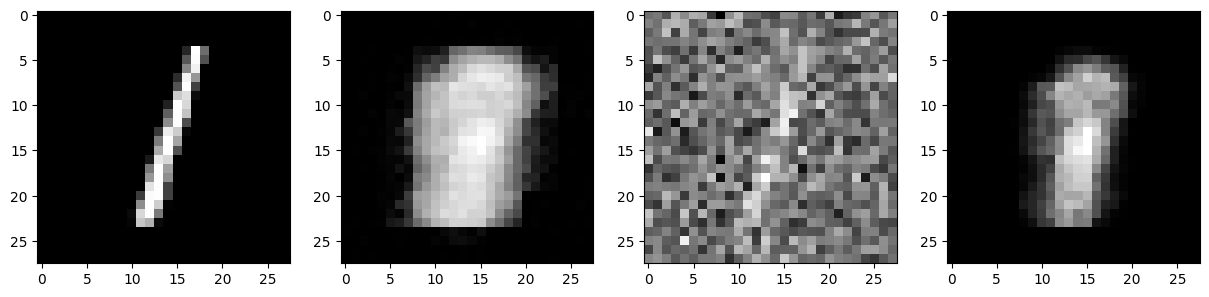

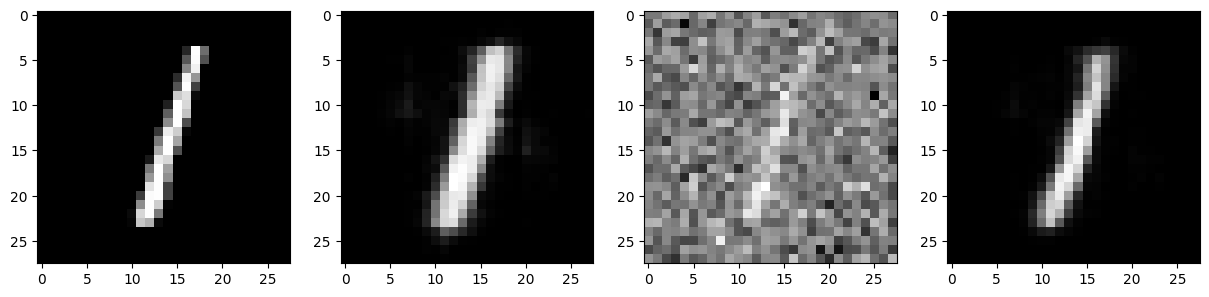

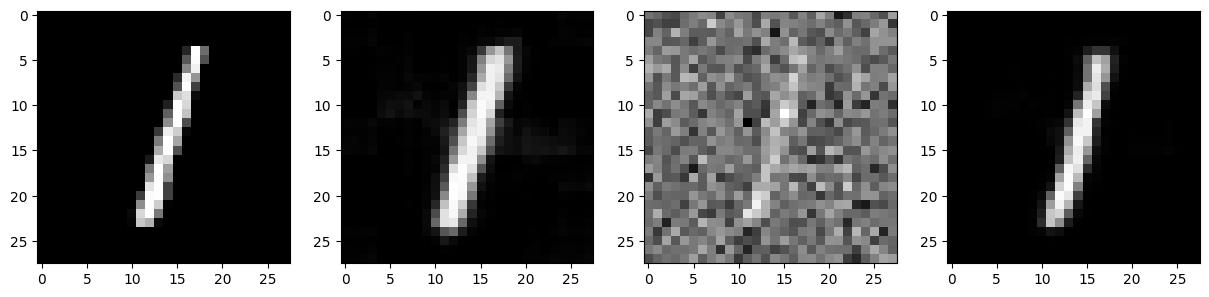

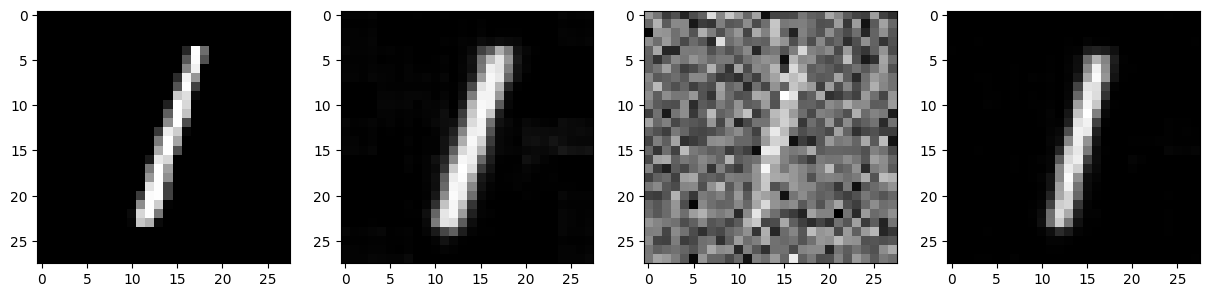

In [17]:
torch.cuda.empty_cache()
model = train(config_dae, True)

In [18]:
pure_rand_noise = torch.randn(torch.Size([1, 28, 28]))

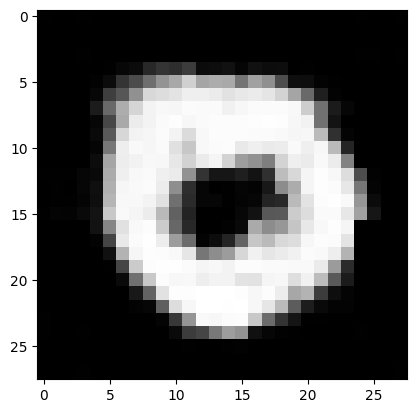

In [33]:
pure_rand_noise = torch.randn(torch.Size([1, 28, 28]))
pure_rand_noise = pure_rand_noise.unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    for i in range(10):
        pure_rand_noise, _ = model(pure_rand_noise)

pure_rand_noise = pure_rand_noise.squeeze(0).cpu()
plt.imshow(pure_rand_noise.numpy()[0], cmap='gray')

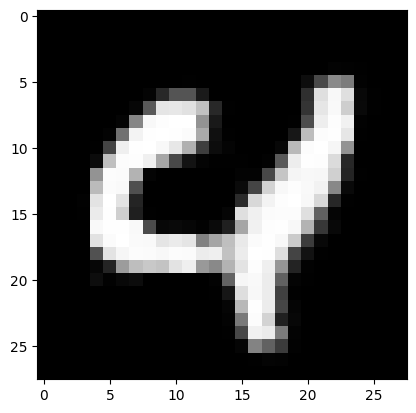

In [26]:
pure_rand_noise = torch.randn(torch.Size([1, 28, 28]))
pure_rand_noise = pure_rand_noise.unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    for i in range(10):
        pure_rand_noise, _ = model_cae(pure_rand_noise)

pure_rand_noise = pure_rand_noise.squeeze(0).cpu()
plt.imshow(pure_rand_noise.numpy()[0], cmap='gray')